# Noise distribution on images with and without noise


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from utils.experiments_functions import get_img_info_simple
import utils.noise_generator as noise_gen
import utils.utils as utils_functions

## Reviewing the sintorn dataset classes

Found 25 image classes with suffix '-r000-s001'
Classes: ['canesugar01', 'canvas01', 'couscous01', 'fabric01', 'fabric02', 'fabric03', 'fabric04', 'fabric05', 'flaxseed01', 'knitwear01', 'knitwear02', 'knitwear03', 'lentils01', 'oatmeal01', 'pearlsugar01', 'rice01', 'rug01', 'ryeflakes01', 'seeds01', 'seeds02', 'sprinkles01', 'tile01', 'towel01', 'wheat01', 'wool01']


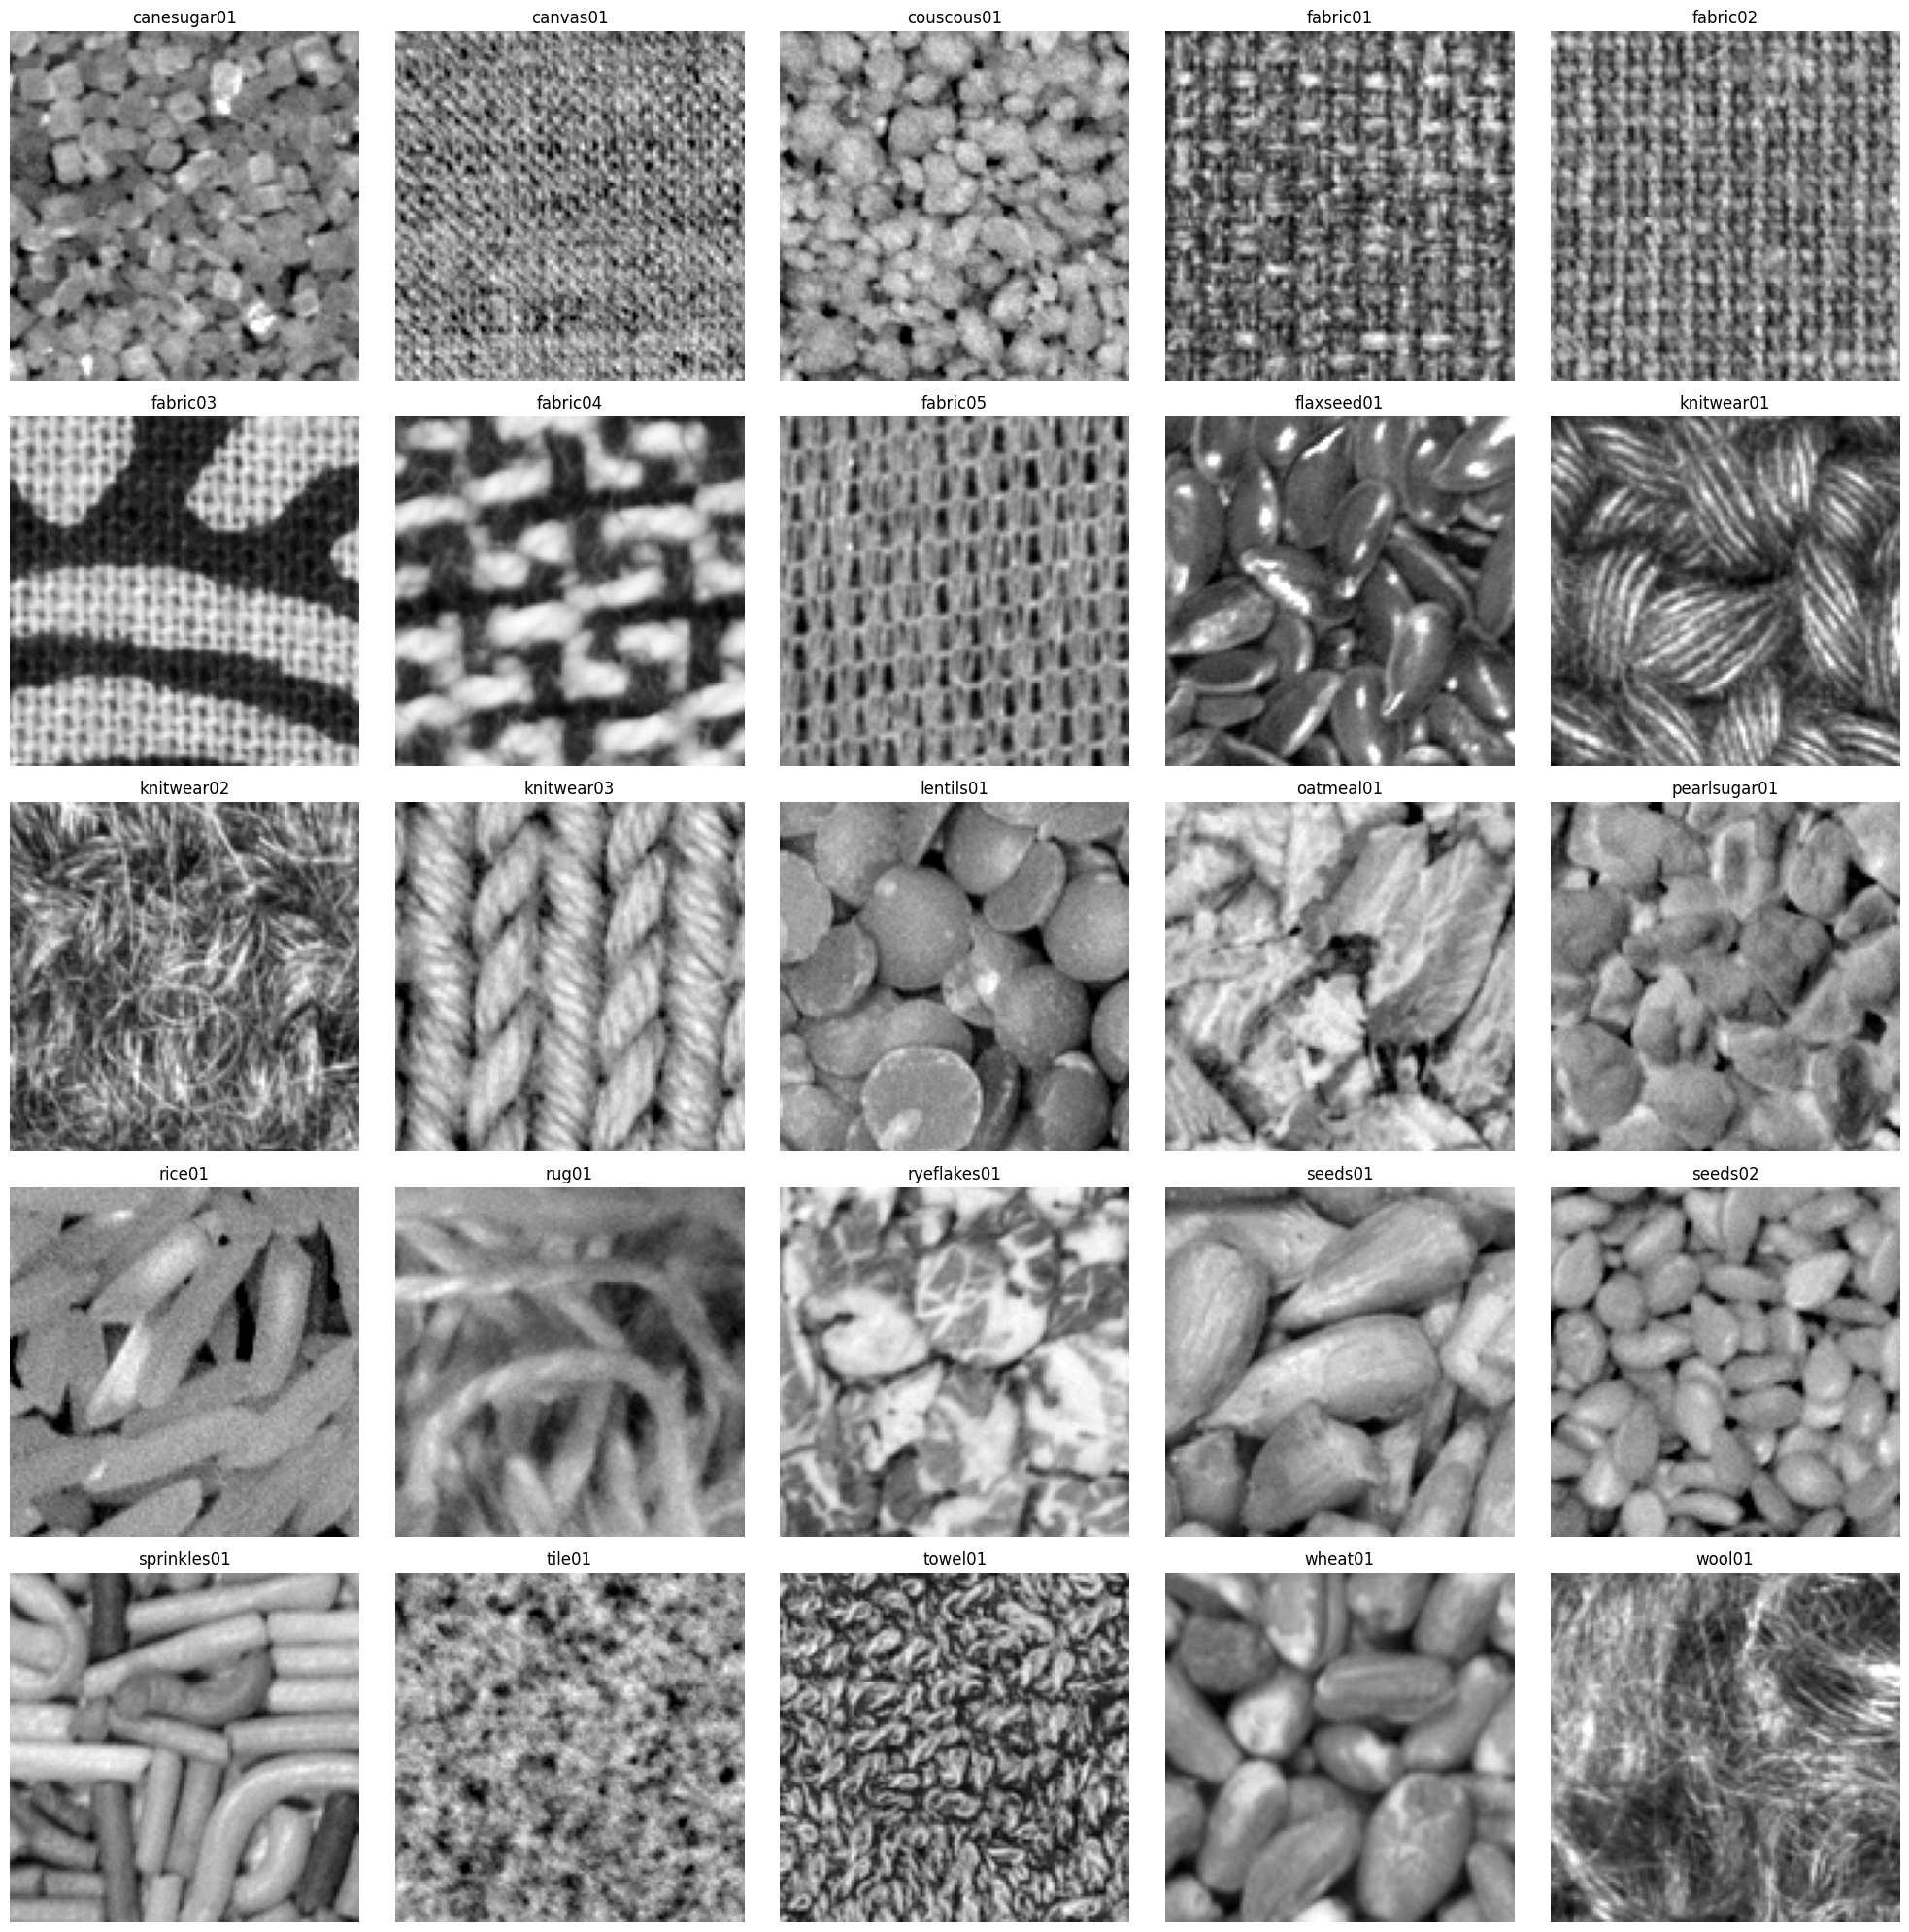

In [2]:
# Get all image files with the specific suffix '-r000-s001'
import glob

images_path = f'data/Sintorn/hardware/'
# Path to the directory
pattern = f'{images_path}*-r000-s001.png'
sample_images = glob.glob(pattern)

# Extract class names from filenames
class_names = [os.path.basename(img).split('-r000-s001')[0] for img in sample_images]
print(f"Found {len(sample_images)} image classes with suffix '-r000-s001'")
print("Classes:", class_names)

# Create a grid of subplots for visualization
n_images = len(sample_images)
cols = min(5, n_images)  # Maximum 5 images per row
rows = (n_images + cols - 1) // cols  # Calculate needed rows

plt.figure(figsize=(cols * 4, rows * 4))

# Plot each image with its class name as title
for i, (img_path, class_name) in enumerate(zip(sample_images, class_names)):
    # Read image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Create subplot
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(class_name, fontsize=12)
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.savefig("results/qualificacao_noises/sintorn_distribution/sample_classes.png", dpi=300, bbox_inches='tight')
plt.show()


## Extracting the metric from Sintorn dataset

Reading images filenames

In [3]:
import glob

# Path to the directory
images_path = f'data/Sintorn/hardware/'
images_class = 'seeds02'

# Get all files with the prefix <images_class> in the directory
images_full_path = glob.glob(f"{images_path}*{images_class}*")

# Extract just the filenames without the path
images_filenames = [os.path.basename(path) for path in images_full_path]

print(f"Found {len(images_filenames)} files with prefix '{images_class}'")
print("First 5 filenames:", images_filenames[:5] if len(images_filenames) >= 5 else images_filenames)


Found 900 files with prefix 'seeds02'
First 5 filenames: ['seeds02-r000-s001.png', 'seeds02-r000-s002.png', 'seeds02-r000-s003.png', 'seeds02-r000-s004.png', 'seeds02-r000-s005.png']


uint8
MIN 0 MAX 235


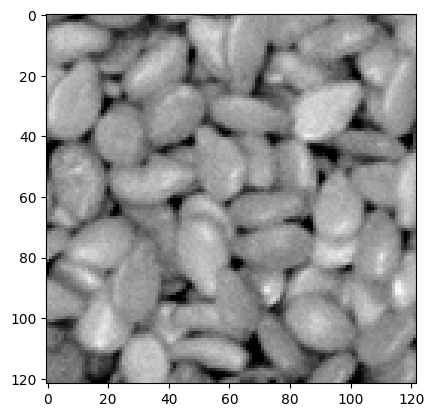

In [4]:
gs_image = cv2.imread(f'{images_path}/{images_filenames[0]}', cv2.IMREAD_GRAYSCALE)
plt.imshow(gs_image, cmap='gray')
print(gs_image.dtype)
print("MIN", gs_image.min(), "MAX", gs_image.max())

float64
MIN 0.0 MAX 0.9215686274509803


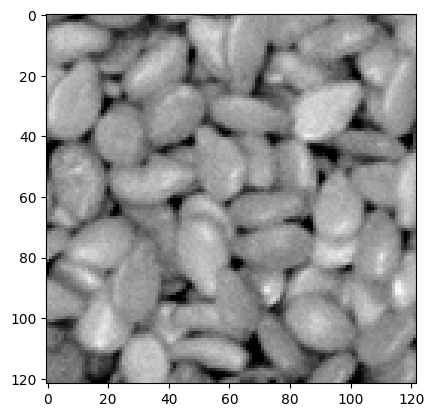

In [5]:
gs_image_float = utils_functions.normalize_uint8_to_float64(gs_image)
plt.imshow(gs_image_float, cmap='gray')
print(gs_image_float.dtype)
print("MIN", gs_image_float.min(), "MAX", gs_image_float.max())

Extracting metrics

In [6]:
# Process all images
noise_types = ['original', 'salt_and_pepper', 'speckle', 'gaussian', 'poisson']

# sets the probabilities used
noise_param_sp = [0.05, 0.1, 0.2, 0.3, 0.4] # salt and pepper
noise_param_gaussian = [0.2, 0.4, 0.6, 0.8] # gaussian
noise_param_speckle = [0.2, 0.6, 1.0, 1.4] # speckle
noise_param_poisson = [0.5, 3.0, 10.0, 30.0] # poisson

image_data_list = []
for idx, img_filename in enumerate(images_filenames):
    # reads the image
    gs_image = cv2.imread(f'{images_path}/{img_filename}', cv2.IMREAD_GRAYSCALE)
    image_title = img_filename.split('.')[0]
    print(image_title, f"{idx+1}/{len(images_filenames)}")
    # normalize the image	
    gs_image = utils_functions.normalize_uint8_to_float64(gs_image)
    # extract metrics
    print("\tExtracting data")
    image_data = get_img_info_simple(gs_image)
    # add the information
    image_data['image_name'] = img_filename
    image_data['noise_type'] = 'original'
    image_data['noise_param'] = 0
    image_data_list.append(image_data)

    # adds s&p noise
    print("\tAdding S&P noise")
    for prob in noise_param_sp:
        print(f"\t\tProbability = {prob}")
        # generate noise image
        print("\t\tGenerating noised image")
        noised_image = noise_gen.add_sp_noise(gs_image, prob, prob)
        # extract metrics
        print("\t\tExtracting data")
        noised_image_data = get_img_info_simple(noised_image)
        # add the information
        noised_image_data['image_name'] = img_filename
        noised_image_data['noise_type'] = 'salt_and_pepper'
        noised_image_data['noise_param'] = prob
        image_data_list.append(noised_image_data)
    # adds gaussian noise
    print("\tAdding Gaussian noise")
    for param in noise_param_gaussian:
        print(f"\t\tSigma = {param}")
        # generate noise image
        print("\t\tGenerating noised image")
        noised_image = noise_gen.add_gaussian_noise(image=gs_image, mean=0, sigma=param)
        # extract metrics
        print("\t\tExtracting data")
        noised_image_data = get_img_info_simple(noised_image)
        # add the information
        noised_image_data['image_name'] = img_filename
        noised_image_data['noise_type'] = 'gaussian'
        noised_image_data['noise_param'] = param
        image_data_list.append(noised_image_data)
    # adds speckle noise
    print("\tAdding Speckle noise")
    for param in noise_param_speckle:
        print(f"\t\tSigma = {param}")
        # generate noise image
        print("\t\tGenerating noised image")
        noised_image = noise_gen.add_speckle_noise(gs_image, mean=0, sigma=param)
        # extract metrics
        print("\t\tExtracting data")
        noised_image_data = get_img_info_simple(noised_image)
        # add the information
        noised_image_data['image_name'] = img_filename
        noised_image_data['noise_type'] = 'speckle'
        noised_image_data['noise_param'] = param
        image_data_list.append(noised_image_data)
    # adds poisson noise
    print("\tAdding Poisson noise")
    for factor in noise_param_poisson:
        print(f"\t\tFactor = {factor}")
        # generate noise image
        print("\t\tGenerating noised image")
        noised_image = noise_gen.add_poisson_noise_normalized(gs_image, factor)
        # extract metrics
        print("\t\tExtracting data")
        noised_image_data = get_img_info_simple(noised_image)
        # add the information
        noised_image_data['image_name'] = img_filename
        noised_image_data['noise_type'] = 'poisson'
        noised_image_data['noise_param'] = factor
        image_data_list.append(noised_image_data)

seeds02-r000-s001 1/900
	Extracting data
	Adding S&P noise
		Probability = 0.05
		Generating noised image
		Extracting data
		Probability = 0.1
		Generating noised image
		Extracting data
		Probability = 0.2
		Generating noised image
		Extracting data
		Probability = 0.3
		Generating noised image
		Extracting data
		Probability = 0.4
		Generating noised image
		Extracting data
	Adding Gaussian noise
		Sigma = 0.2
		Generating noised image
		Extracting data
		Sigma = 0.4
		Generating noised image
		Extracting data
		Sigma = 0.6
		Generating noised image
		Extracting data
		Sigma = 0.8
		Generating noised image
		Extracting data
	Adding Speckle noise
		Sigma = 0.2
		Generating noised image
		Extracting data
		Sigma = 0.6
		Generating noised image
		Extracting data
		Sigma = 1.0
		Generating noised image
		Extracting data
		Sigma = 1.4
		Generating noised image
		Extracting data
	Adding Poisson noise
		Factor = 0.5
		Generating noised image
		Extracting data
		Factor = 3.0
		Generating no

In [7]:
data_default_aux = pd.concat(image_data_list, ignore_index=True)
data_default_aux.to_csv(f"results/qualificacao_noises/sintorn_distribution/metrics_{images_class}.csv", index=False)

## Importing the CSV

In [12]:
images_class = 'fabric03'
data_default_aux = pd.read_csv(f"results/qualificacao_noises/sintorn_distribution/metrics_{images_class}.csv")
data_default_aux.head(5)

Smoothness  Curve structure   Entropy  Complexity              image_name  \
0    0.367848         0.207978  0.875840    0.151563  fabric03-r000-s001.png   
1    0.221274         0.200055  0.945989    0.068723  fabric03-r000-s001.png   
2    0.125174         0.170207  0.974940    0.032355  fabric03-r000-s001.png   
3    0.024771         0.110375  0.983446    0.021631  fabric03-r000-s001.png   
4    0.025522         0.059490  0.954226    0.058491  fabric03-r000-s001.png   

        noise_type  noise_param  
0         original         0.00  
1  salt_and_pepper         0.05  
2  salt_and_pepper         0.10  
3  salt_and_pepper         0.20  
4  salt_and_pepper         0.30

## Generating boxplots

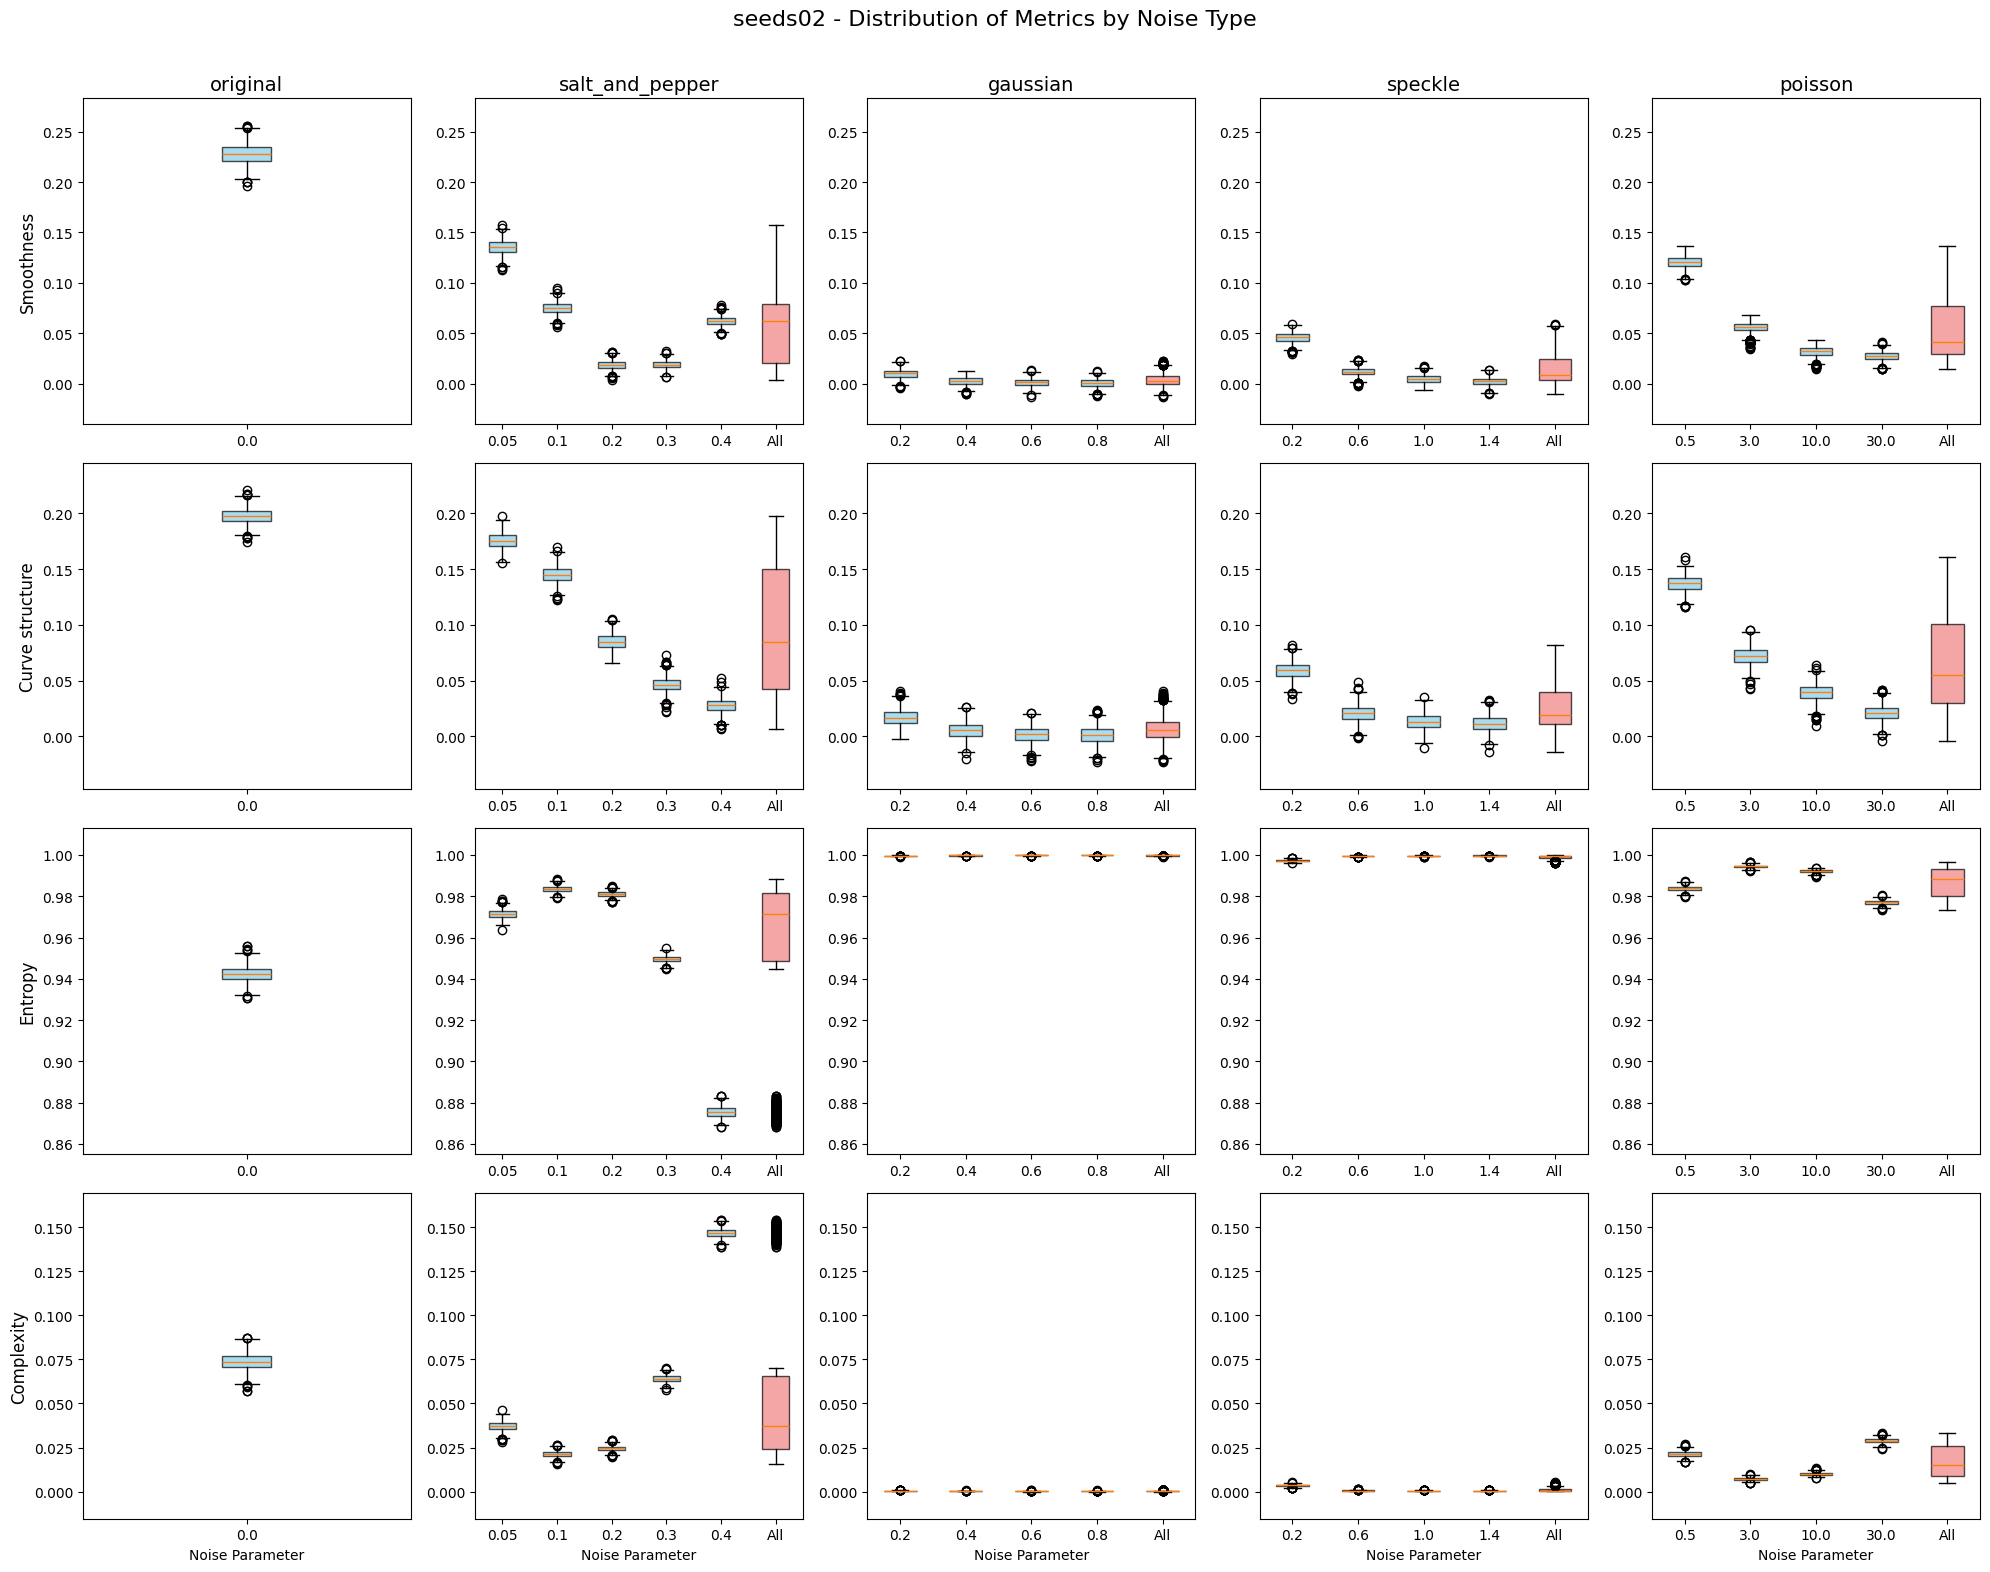

In [9]:
# Create a figure with 4x5 subplots (4 metrics x 5 noise types)
fig, axs = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle(f'{images_class} - Distribution of Metrics by Noise Type', fontsize=16)

# Define metrics and noise types
metrics = ['Smoothness', 'Curve structure', 'Entropy', 'Complexity']
noise_types_list = data_default_aux['noise_type'].unique()

# Set column titles (noise types)
for j, noise_type in enumerate(noise_types_list):
    axs[0, j].set_title(noise_type, fontsize=14)

# Determine y-axis limits for each metric
y_limits = {}
for metric in metrics:
    min_val = data_default_aux[metric].min()
    max_val = data_default_aux[metric].max()
    # Add some padding (10% of the range)
    padding = (max_val - min_val) * 0.1
    y_limits[metric] = [min_val - padding, max_val + padding]

# Create boxplots for each metric and noise type
for i, metric in enumerate(metrics):
    # Set row labels (metrics)
    axs[i, 0].set_ylabel(metric, fontsize=12)
    
    # For each noise type, create a boxplot for the current metric
    for j, noise_type in enumerate(noise_types_list):
        # Filter data for the current noise type
        noise_data = data_default_aux[data_default_aux['noise_type'] == noise_type]
        
        # Group by noise parameter for the current metric
        grouped_data = [group[metric].values for param, group in noise_data.groupby('noise_param')]
        group_labels = [str(param) for param in sorted(noise_data['noise_param'].unique())]
        
        # Add "All" category for non-original noise types
        if noise_type != 'original':
            grouped_data.append(noise_data[metric].values)
            group_labels.append('All')
        
        # Create boxplot
        bp = axs[i, j].boxplot(grouped_data, labels=group_labels, patch_artist=True)
        
        # Customize boxplot colors
        for k, box in enumerate(bp['boxes']):
            # Use a different color for the "All" box
            if k == len(grouped_data) - 1 and noise_type != 'original':
                box.set(facecolor='lightcoral', alpha=0.7)
            else:
                box.set(facecolor='skyblue', alpha=0.7)
        
        # Set x-label on the bottom row
        if i == 3:
            axs[i, j].set_xlabel('Noise Parameter', fontsize=10)
        
        # Set consistent y-axis limits for the same metric
        axs[i, j].set_ylim(y_limits[metric])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"results/qualificacao_noises/sintorn_distribution/metrics_{images_class}_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()


## Comparing the classes (Boxplot)

Loading data for seeds02...
Loading data for fabric03...
Loading data for canesugar01...


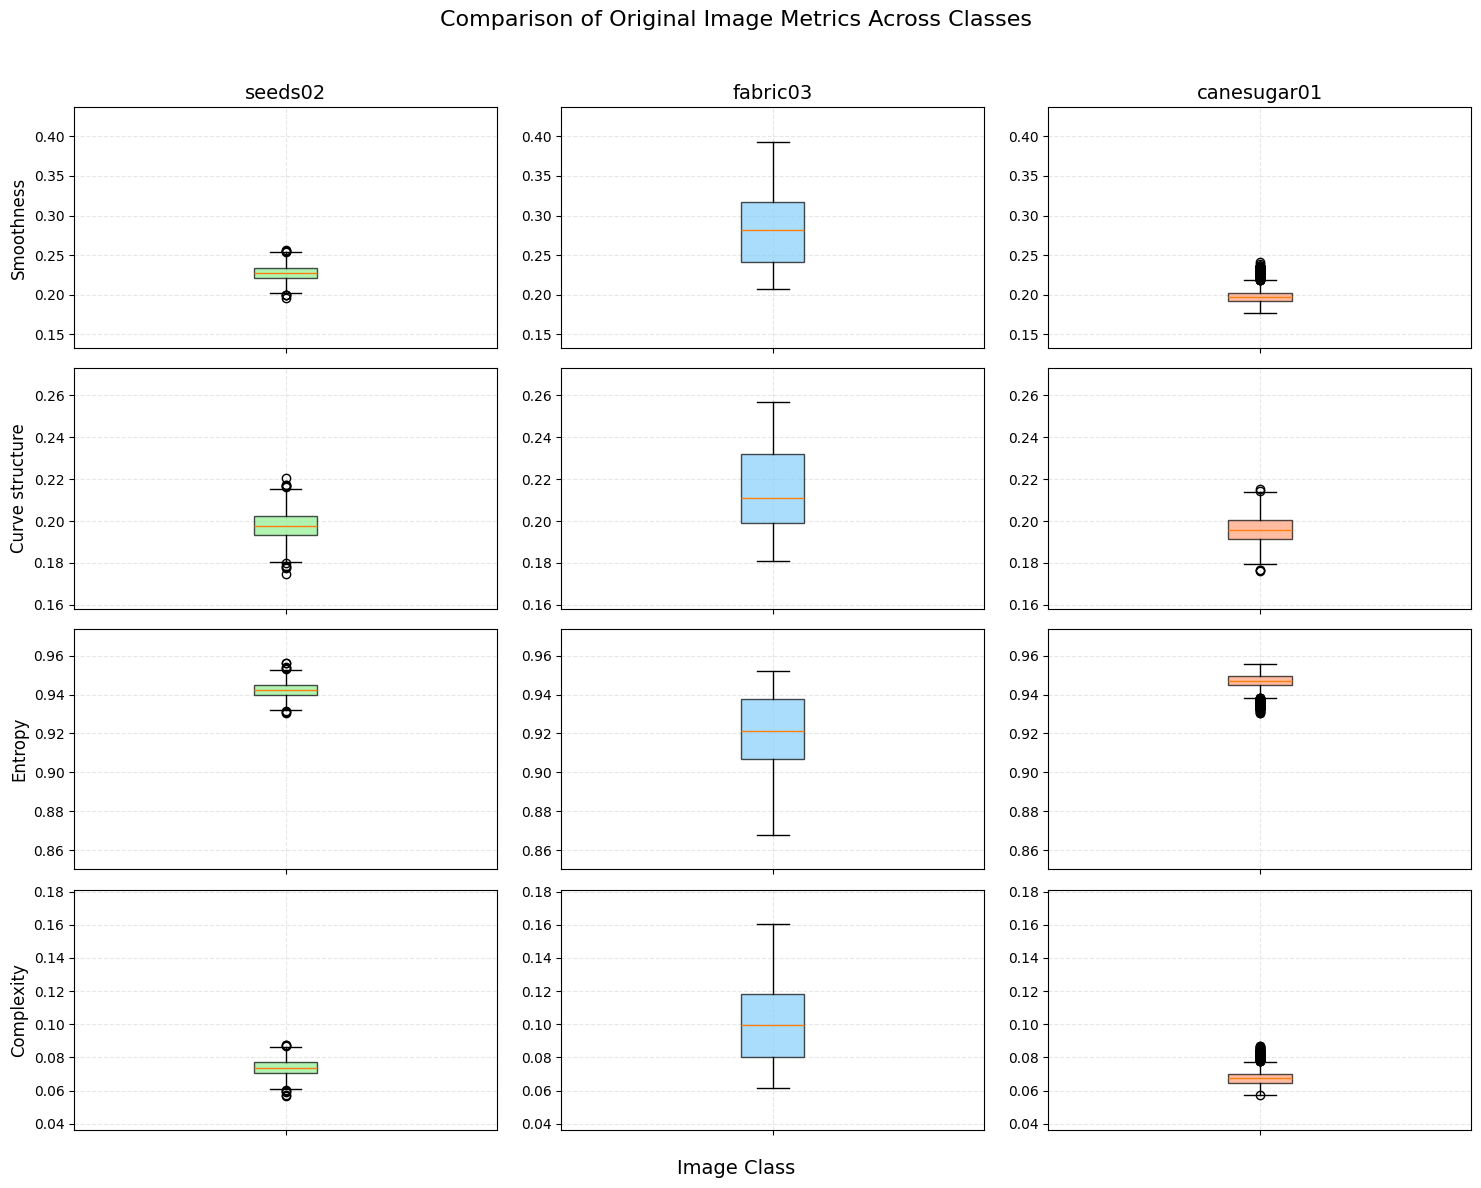

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the image classes to compare
image_classes = ['seeds02', 'fabric03', 'canesugar01']

# Load data from each class
dataframes = {}
all_data = []

for img_class in image_classes:
    try:
        print(f"Loading data for {img_class}...")
        df = pd.read_csv(f"results/qualificacao_noises/sintorn_distribution/metrics_{img_class}.csv")
        # Filter for original images only
        original_df = df[df['noise_type'] == 'original']
        dataframes[img_class] = original_df
        all_data.append(original_df)
    except FileNotFoundError:
        print(f"Data for {img_class} not found. Make sure to process this class first.")
        print(f"Hint: Run the processing code with images_class = '{img_class}'")

# If any data is missing, we need to generate it
if len(dataframes) < len(image_classes):
    missing_classes = [c for c in image_classes if c not in dataframes]
    print(f"Please generate data for: {', '.join(missing_classes)}")
else:
    # Combine all data for calculating consistent y-axis limits
    combined_data = pd.concat(all_data, ignore_index=True)
    
    # Define metrics
    metrics = ['Smoothness', 'Curve structure', 'Entropy', 'Complexity']
    
    # Create a figure with metrics as rows and classes as columns
    fig, axs = plt.subplots(len(metrics), len(image_classes), figsize=(15, 12))
    fig.suptitle(f'Comparison of Original Image Metrics Across Classes', fontsize=16)
    
    # Set column titles (image classes)
    for j, img_class in enumerate(image_classes):
        axs[0, j].set_title(img_class, fontsize=14)
    
    # Determine global y-axis limits for each metric to ensure consistent scales
    y_limits = {}
    for metric in metrics:
        min_val = combined_data[metric].min()
        max_val = combined_data[metric].max()
        # Add some padding (20% of the range)
        padding = (max_val - min_val) * 0.2
        y_limits[metric] = [max(0, min_val - padding), max_val + padding]
    
    # Create boxplots for each metric and class
    for i, metric in enumerate(metrics):
        # Set row labels (metrics)
        axs[i, 0].set_ylabel(metric, fontsize=12)
        
        # For each image class, create a boxplot for the current metric
        for j, img_class in enumerate(image_classes):
            df = dataframes[img_class]
            
            # Create boxplot for this metric and class
            # We're plotting all original images for each class
            bp = axs[i, j].boxplot(df[metric].values, patch_artist=True)
            
            # Customize boxplot colors - use different colors for different classes
            colors = ['lightgreen', 'lightskyblue', 'lightsalmon']
            for box in bp['boxes']:
                box.set(facecolor=colors[j], alpha=0.7)
            
            # Set consistent y-axis limits for all plots of the same metric
            axs[i, j].set_ylim(y_limits[metric])
            
            # Add grid for easier comparison
            axs[i, j].grid(True, alpha=0.3, linestyle='--')
            
            # Remove x-tick labels since we're not comparing variants within a class
            axs[i, j].set_xticklabels([])
            
            # Show data points on top of boxplots for better visibility
            if len(df) < 50:  # Only show individual points if not too many
                y = df[metric].values
                x = np.random.normal(1, 0.1, size=len(y))  # Add jitter
                axs[i, j].scatter(x, y, alpha=0.5, s=15, color='darkblue')
    
    # Add an overall x-axis label at the bottom of the figure
    fig.text(0.5, 0.01, 'Image Class', ha='center', fontsize=14)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig("results/qualificacao_noises/sintorn_distribution/original_metrics_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

## Generating distribution

In [13]:
import seaborn as sns

# Create a figure with 4x5 subplots (4 metrics x 5 noise types)
fig, axs = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle(f'{images_class} - Distribution of Metrics by Noise Type', fontsize=16)

# Define metrics and noise types
metrics = ['Smoothness', 'Curve structure', 'Entropy', 'Complexity']
noise_types_list = data_default_aux['noise_type'].unique()

# Set column titles (noise types)
for j, noise_type in enumerate(noise_types_list):
    axs[0, j].set_title(noise_type, fontsize=14)

# Determine x-axis limits for each metric (for consistent visualization)
x_limits = {}
for metric in metrics:
    min_val = data_default_aux[metric].min()
    max_val = data_default_aux[metric].max()
    # Add some padding (10% of the range)
    padding = (max_val - min_val) * 0.1
    x_limits[metric] = [min_val - padding, max_val + padding]

# Color palette for different noise parameters
# We'll use a colormap for parameters and a distinct color for "All"
param_cmap = plt.cm.viridis
all_category_color = 'red'

# Create KDE plots for each metric and noise type
for i, metric in enumerate(metrics):
    # Set row labels (metrics) on the first column only
    axs[i, 0].set_ylabel(metric, fontsize=12)
    
    # For each noise type, create KDE plots for the current metric
    for j, noise_type in enumerate(noise_types_list):
        # Filter data for the current noise type
        noise_data = data_default_aux[data_default_aux['noise_type'] == noise_type]
        
        # Get unique parameter values and sort them
        param_values = sorted(noise_data['noise_param'].unique())
        num_params = len(param_values)
        
        # Generate colors for each parameter value
        param_colors = {param: param_cmap(idx/max(1, num_params-1)) 
                       for idx, param in enumerate(param_values)}
        
        # Plot KDE for each parameter value
        legend_handles = []
        legend_labels = []
        
        # Set consistent x-axis limits
        axs[i, j].set_xlim(x_limits[metric])
        
        # Plot individual parameter distributions
        for param in param_values:
            param_data = noise_data[noise_data['noise_param'] == param]
            sns.kdeplot(
                data=param_data[metric],
                ax=axs[i, j],
                color=param_colors[param],
                lw=2,
                fill=True,
                alpha=0.3,
                label=str(param),
                common_norm=False,  # Don't normalize curves together
                bw_adjust=0.8  # Adjust bandwidth for smoother curves
            )
            legend_handles.append(plt.Line2D([0], [0], color=param_colors[param], lw=2))
            legend_labels.append(str(param))
        
        # Add "All" category for non-original noise types
        if noise_type != 'original':
            sns.kdeplot(
                data=noise_data[metric],
                ax=axs[i, j],
                color=all_category_color,
                lw=2.5,
                fill=False,
                alpha=0.8,
                label='All',
                common_norm=False,
                linestyle='--',
                bw_adjust=1.0  # Slightly wider bandwidth for the aggregated data
            )
            legend_handles.append(plt.Line2D([0], [0], color=all_category_color, lw=2.5, linestyle='--'))
            legend_labels.append('All')
        
        # Add legend with smaller font
        if len(legend_handles) <= 6:  # Only show legend if not too crowded
            axs[i, j].legend(
                handles=legend_handles,
                labels=legend_labels,
                title='Noise Param',
                fontsize=8,
                title_fontsize=9,
                loc='upper right'
            )
        
        # Remove y-axis labels for all except the first column
        if j > 0:
            axs[i, j].set_ylabel('')
        axs[i, j].set_ylim(bottom=0)  # Start from 0

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"results/qualificacao_noises/sintorn_distribution/metrics_{images_class}_kde.png", dpi=300, bbox_inches='tight')
plt.show()

## Comparing the classes (KDEplot)

Loading data for seeds02...
Loading data for fabric03...
Loading data for canesugar01...


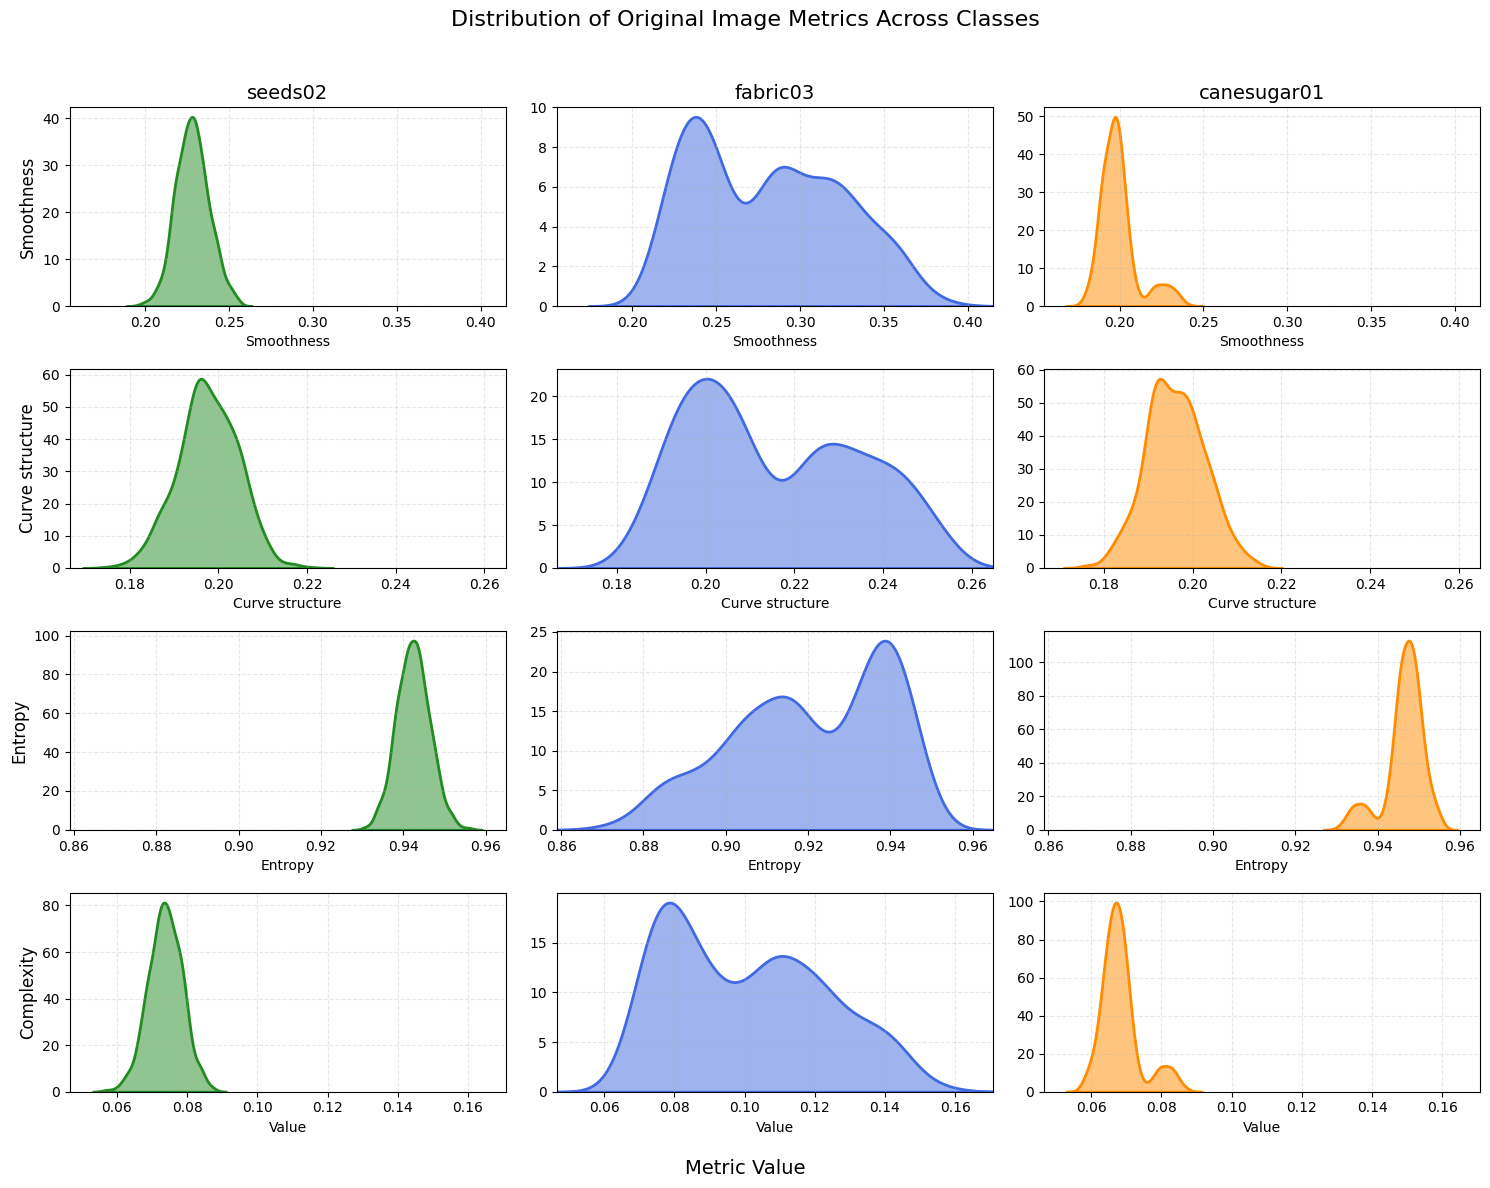

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the image classes to compare
image_classes = ['seeds02', 'fabric03', 'canesugar01']

# Load data from each class
dataframes = {}
all_data = []

for img_class in image_classes:
    try:
        print(f"Loading data for {img_class}...")
        df = pd.read_csv(f"results/qualificacao_noises/sintorn_distribution/metrics_{img_class}.csv")
        # Filter for original images only
        original_df = df[df['noise_type'] == 'original']
        dataframes[img_class] = original_df
        all_data.append(original_df)
    except FileNotFoundError:
        print(f"Data for {img_class} not found. Make sure to process this class first.")
        print(f"Hint: Run the processing code with images_class = '{img_class}'")

# If any data is missing, we need to generate it
if len(dataframes) < len(image_classes):
    missing_classes = [c for c in image_classes if c not in dataframes]
    print(f"Please generate data for: {', '.join(missing_classes)}")
else:
    # Combine all data for calculating consistent x-axis limits
    combined_data = pd.concat(all_data, ignore_index=True)
    
    # Define metrics
    metrics = ['Smoothness', 'Curve structure', 'Entropy', 'Complexity']
    
    # Create a figure with metrics as rows and classes as columns
    fig, axs = plt.subplots(len(metrics), len(image_classes), figsize=(15, 12))
    fig.suptitle(f'Distribution of Original Image Metrics Across Classes', fontsize=16)
    
    # Set column titles (image classes)
    for j, img_class in enumerate(image_classes):
        axs[0, j].set_title(img_class, fontsize=14)
    
    # Determine global x-axis limits for each metric to ensure consistent scales
    x_limits = {}
    for metric in metrics:
        min_val = combined_data[metric].min()
        max_val = combined_data[metric].max()
        # Add some padding (10% of the range)
        padding = (max_val - min_val) * 0.1
        x_limits[metric] = [max(0, min_val - padding), max_val + padding]
    
    # Define colors for each class
    class_colors = {
        'seeds02': 'forestgreen',
        'fabric03': 'royalblue',
        'canesugar01': 'darkorange'
    }
    
    # Create KDE plots for each metric and class
    for i, metric in enumerate(metrics):
        # Set row labels (metrics)
        axs[i, 0].set_ylabel(metric, fontsize=12)
        
        # For each image class, create a KDE plot for the current metric
        for j, img_class in enumerate(image_classes):
            df = dataframes[img_class]
            
            # Create KDE plot for this metric and class
            sns.kdeplot(
                data=df[metric],
                ax=axs[i, j],
                color=class_colors[img_class],
                lw=2,
                fill=True,
                alpha=0.5,
                common_norm=False,  # Don't normalize curves together
                bw_adjust=1.0  # Adjust bandwidth for smoother curves
            )
            
            # Set consistent x-axis limits for all plots of the same metric
            axs[i, j].set_xlim(x_limits[metric])
            
            # Set y-axis to start at 0
            axs[i, j].set_ylim(bottom=0)
            
            # Add grid for easier comparison
            axs[i, j].grid(True, alpha=0.3, linestyle='--')
            
            # Set x-label on the bottom row only
            if i == len(metrics) - 1:
                axs[i, j].set_xlabel('Value', fontsize=10)
            
            # Show data points as rug plot at the bottom
            if len(df) < 50:  # Only show individual points if not too many
                sns.rugplot(
                    data=df[metric], 
                    ax=axs[i, j],
                    color=class_colors[img_class],
                    alpha=0.7,
                    height=0.05
                )
            
            # Remove y-axis labels for cleaner look (density is less important than shape)
            if j > 0:  # Keep ylabel only for the first column
                axs[i, j].set_ylabel('')
    
    # Add an overall x-axis label at the bottom of the figure
    fig.text(0.5, 0.01, 'Metric Value', ha='center', fontsize=14)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig("results/qualificacao_noises/sintorn_distribution/original_metrics_kde_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()